# 03 — Training + Tuning + Stacking (2024 window, Jan–Okt train → Nov–Des test)

**Target flow**  
Feature Extraction: CountVectorizer, TF-IDF  
Models: Naive Bayes, SVM, **Logistic Regression**  
Cross-Validation: stratified di data train (Jan–Okt 2024)  
SMOTE: opsional (tidak disarankan untuk teks, tapi contoh disediakan)  
Hyperparameter Tuning: **RandomizedSearchCV** (RAM-safe)  
Ensemble: **Stacking** (NB + Calibrated SVM + LR, meta=LR)

**Hold-out test:** Nov–Des 2024 (time-based).  
**Deployment / inference:** 2025 window (di notebook #04).


In [2]:
%%time
# Install & imports
%pip install -q scikit-learn imbalanced-learn joblib matplotlib

import os, json, warnings
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import sklearn
warnings.filterwarnings("ignore")
np.random.seed(42)
print("✅ Imports ready | sklearn", sklearn.__version__)


Note: you may need to restart the kernel to use updated packages.
✅ Imports ready | sklearn 1.6.1
CPU times: total: 828 ms
Wall time: 3.41 s


## 1) Load data & definisi split waktu
- Input: `reddit_opinion_PSE_ISR_2024_window_labeled_textblob.csv`
- **Train** = `2024-01 … 2024-10`  
- **Test**  = `2024-11 … 2024-12`


In [3]:
%%time
INPUT_LABELED = "reddit_opinion_PSE_ISR_2024_window_labeled_textblob.csv"
ARTE_DIR      = "artefacts_2024_window_full"
os.makedirs(ARTE_DIR, exist_ok=True)

ALL_LABELS = ["Positif","Netral","Negatif"]
TEXT_PREF  = ["final_text","self_text"]  

assert os.path.exists(INPUT_LABELED), f"Tidak ditemukan: {INPUT_LABELED}"
df = pd.read_csv(INPUT_LABELED, low_memory=False)

TEXT_COL = next((c for c in TEXT_PREF if c in df.columns and df[c].notna().any()), None)
assert TEXT_COL is not None, "Tidak ada kolom teks valid (final_text/self_text)."

if "month" not in df.columns:
    df["created_time"] = pd.to_datetime(df["created_time"], errors="coerce")
    df = df[df["created_time"].notna()].copy()
    df["month"] = df["created_time"].dt.to_period("M").astype(str)

df = df[df["label"].isin(ALL_LABELS)].copy()
df["text"] = df[TEXT_COL].astype(str).str.strip()
df = df[df["text"] != ""].copy()

train_months = [f"2024-{m:02d}" for m in range(1,11)]
test_months  = ["2024-11","2024-12"]

df_tr = df[df["month"].isin(train_months)].copy()
df_te = df[df["month"].isin(test_months)].copy()

print(f"Train rows: {len(df_tr):,} | Test rows: {len(df_te):,}")
print("Train label dist:\n", df_tr["label"].value_counts())
print("\nTest label dist:\n",  df_te["label"].value_counts())


Train rows: 493,903 | Test rows: 64,941
Train label dist:
 label
Netral     229249
Positif    154622
Negatif    110032
Name: count, dtype: int64

Test label dist:
 label
Netral     30622
Positif    20329
Negatif    13990
Name: count, dtype: int64
CPU times: total: 5.94 s
Wall time: 5.97 s


## 2) X, y & Cross-Validation (stratified, dinamika fold)


In [4]:
%%time
X_tr = df_tr["text"].values
y_tr = df_tr["label"].values
X_te = df_te["text"].values
y_te = df_te["label"].values

min_count = int(df_tr["label"].value_counts().min())
cv_folds  = max(3, min(5, min_count))
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
print(f"✅ CV: Stratified {cv_folds}-fold (min class in train = {min_count})")


✅ CV: Stratified 5-fold (min class in train = 110032)
CPU times: total: 0 ns
Wall time: 15.5 ms


## 3) Vectorizer defaults & helper Calibrated SVM
- Dua extractor: **TF-IDF** dan **Count** (1–2-gram).
- `CalibratedClassifierCV` butuh kompatibilitas argumen (`estimator` vs `base_estimator`).


In [5]:
%%time
TFIDF_KW = dict(
    lowercase=True, ngram_range=(1,2),
    min_df=5, max_df=0.9, sublinear_tf=True,
    max_features=150_000, dtype=np.float32
)
COUNT_KW = dict(
    lowercase=True, ngram_range=(1,2),
    min_df=5, max_df=0.9,
    max_features=150_000, dtype=np.int32, binary=False
)

def make_calibrated_svm(C=1.0):
    try:
        return CalibratedClassifierCV(
            estimator=LinearSVC(C=C, class_weight="balanced", random_state=42, max_iter=5000),
            cv=3, method="sigmoid"
        )
    except TypeError:
        return CalibratedClassifierCV(
            base_estimator=LinearSVC(C=C, class_weight="balanced", random_state=42, max_iter=5000),
            cv=3, method="sigmoid"
        )
print("✅ Vectorizers & SVM calibrator ready")


✅ Vectorizers & SVM calibrator ready
CPU times: total: 0 ns
Wall time: 252 μs


## 4) Kandidat pipelines
- **TF-IDF / Count** × (**ComplementNB**, **LinearSVC**, **LogisticRegression**)
- **Stacking** (NB + Calibrated SVM + LR, meta=LR) — dengan TF-IDF dan Count


In [6]:
%%time
from sklearn.ensemble import StackingClassifier

# Single models (TF-IDF)
pipe_tfidf_nb  = Pipeline([("vect", TfidfVectorizer(**TFIDF_KW)),
                           ("clf",  ComplementNB(alpha=1.0))])
pipe_tfidf_svm = Pipeline([("vect", TfidfVectorizer(**TFIDF_KW)),
                           ("clf",  LinearSVC(C=1.0, class_weight="balanced", random_state=42, max_iter=5000))])
pipe_tfidf_lr  = Pipeline([("vect", TfidfVectorizer(**TFIDF_KW)),
                           ("clf",  LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear",
                                                       max_iter=2000, multi_class="ovr"))])

# Single models (Count)
pipe_count_nb  = Pipeline([("vect", CountVectorizer(**COUNT_KW)),
                           ("clf",  ComplementNB(alpha=1.0))])
pipe_count_svm = Pipeline([("vect", CountVectorizer(**COUNT_KW)),
                           ("clf",  LinearSVC(C=1.0, class_weight="balanced", random_state=42, max_iter=5000))])
pipe_count_lr  = Pipeline([("vect", CountVectorizer(**COUNT_KW)),
                           ("clf",  LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear",
                                                       max_iter=2000, multi_class="ovr"))])

# Stacking (TF-IDF)
stack_tfidf = Pipeline([
    ("vect", TfidfVectorizer(**TFIDF_KW)),
    ("stack", StackingClassifier(
        estimators=[
            ("nb",  ComplementNB(alpha=1.0)),
            ("svm", make_calibrated_svm(C=1.0)),
            ("lr",  LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear",
                                       max_iter=2000, multi_class="ovr"))
        ],
        final_estimator=LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear",
                                           max_iter=2000, multi_class="ovr"),
        stack_method="predict_proba",
        cv=3, n_jobs=1
    ))
])

# Stacking (Count)
stack_count = Pipeline([
    ("vect", CountVectorizer(**COUNT_KW)),
    ("stack", StackingClassifier(
        estimators=[
            ("nb",  ComplementNB(alpha=1.0)),
            ("svm", make_calibrated_svm(C=1.0)),
            ("lr",  LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear",
                                       max_iter=2000, multi_class="ovr"))
        ],
        final_estimator=LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear",
                                           max_iter=2000, multi_class="ovr"),
        stack_method="predict_proba",
        cv=3, n_jobs=1
    ))
])

pipelines = {
    "tfidf_nb": pipe_tfidf_nb,
    "tfidf_svm": pipe_tfidf_svm,
    "tfidf_lr": pipe_tfidf_lr,
    "count_nb": pipe_count_nb,
    "count_svm": pipe_count_svm,
    "count_lr": pipe_count_lr,
    "stack_tfidf": stack_tfidf,
    "stack_count": stack_count
}
print("✅ Pipelines ready:", list(pipelines.keys()))


✅ Pipelines ready: ['tfidf_nb', 'tfidf_svm', 'tfidf_lr', 'count_nb', 'count_svm', 'count_lr', 'stack_tfidf', 'stack_count']
CPU times: total: 0 ns
Wall time: 338 μs


## 5) Hyperparameter Tuning (RandomizedSearchCV, RAM-safe)
- `n_jobs=1` (hindari mem-pickle X besar ke child processes)
- `N_ITER` bisa dinaikkan kalau masih cepat; mulai dari 20–30
- Tuning vektorizer & classifier; untuk stacking: NB α, SVM C, LR C, meta C


In [7]:
%%time
import warnings
warnings.filterwarnings(
    "ignore",
    message=r".*'multi_class'.*",
    category=FutureWarning,
    module=r"sklearn\.linear_model\._logistic"
)

# === Detect key name for CalibratedClassifierCV's inner estimator ===
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

try:
    _ = CalibratedClassifierCV(estimator=LinearSVC(), cv=3, method="sigmoid")
    CALIB_KEY = "estimator"
except TypeError:
    CALIB_KEY = "base_estimator"

svm_c_key_tfidf = f"stack__svm__{CALIB_KEY}__C"
svm_c_key_count = f"stack__svm__{CALIB_KEY}__C"

# === ensure normalization after Count for SVM pipelines ===
from sklearn.feature_extraction.text import TfidfTransformer

def _add_norm_after_vect(pipe):
    """
    Insert TfidfTransformer(use_idf=False, norm='l2', sublinear_tf=True)
    right after 'vect' step if not present. Keeps raw Count features,
    but normalizes them for faster SVM convergence.
    """
    names = [n for n, _ in pipe.steps]
    if "norm" not in names and "vect" in names:
        i = names.index("vect") + 1
        pipe.steps.insert(i, ("norm", TfidfTransformer(use_idf=False, norm="l2", sublinear_tf=True)))
    return pipe

# Update existing pipelines (assumes 'pipelines' already defined earlier)
pipelines["count_svm"]   = _add_norm_after_vect(pipelines["count_svm"])
pipelines["stack_count"] = _add_norm_after_vect(pipelines["stack_count"])

# === Param spaces (original) ===
# (Parameter spaces tidak saya tampilkan ulang di sini agar ringkas, 
#  asumsikan sama seperti kode asli Anda)
param_spaces = {
    "tfidf_nb": {
        "vect__ngram_range": [(1,1),(1,2)], "vect__min_df": [3,5,10],
        "vect__max_df": [0.85,0.9,0.95], "clf__alpha": [0.1,0.5,1.0,2.0],
    },
    "tfidf_svm": {
        "vect__ngram_range": [(1,1),(1,2)], "vect__min_df": [3,5,10],
        "vect__max_df": [0.85,0.9,0.95], "vect__sublinear_tf": [True, False],
        "clf__C": [0.1,0.5,1.0,2.0,5.0], "clf__class_weight": ["balanced"],
        "clf__max_iter": [5000],
    },
    "tfidf_lr": {
        "vect__ngram_range": [(1,1),(1,2)], "vect__min_df": [3,5,10],
        "vect__max_df": [0.85,0.9,0.95], "vect__sublinear_tf": [True, False],
        "clf__C": [0.5,1.0,2.0,5.0], "clf__class_weight": ["balanced"],
        "clf__solver": ["liblinear"], "clf__max_iter": [2000],
    },
    "count_nb": {
        "vect__ngram_range": [(1,1),(1,2)], "vect__min_df": [3,5,10],
        "vect__max_df": [0.85,0.9,0.95], "clf__alpha": [0.1,0.5,1.0,2.0],
    },
    "count_svm": {
        "vect__ngram_range": [(1,1),(1,2)], "vect__min_df": [3,5,10],
        "vect__max_df": [0.85,0.9,0.95], "clf__C": [0.1,0.5,1.0,2.0,5.0],
        "clf__class_weight": ["balanced"], "clf__max_iter": [5000],
    },
    "count_lr": {
        "vect__ngram_range": [(1,1),(1,2)], "vect__min_df": [3,5,10],
        "vect__max_df": [0.85,0.9,0.95], "clf__C": [0.5,1.0,2.0,5.0],
        "clf__class_weight": ["balanced"], "clf__solver": ["liblinear"],
        "clf__max_iter": [2000],
    },
    "stack_tfidf": {
        "vect__ngram_range": [(1,1),(1,2)], "vect__min_df": [3,5,10],
        "vect__max_df": [0.85,0.9,0.95], "vect__sublinear_tf": [True, False],
        "stack__nb__alpha": [0.1,0.5,1.0,2.0], svm_c_key_tfidf: [0.1,0.5,1.0,2.0,5.0],
        "stack__lr__C": [0.5,1.0,2.0,5.0], "stack__final_estimator__C": [0.5,1.0,2.0,5.0],
    },
    "stack_count": {
        "vect__ngram_range": [(1,1),(1,2)], "vect__min_df": [3,5,10],
        "vect__max_df": [0.85,0.9,0.95], "stack__nb__alpha": [0.1,0.5,1.0,2.0],
        svm_c_key_count: [0.1,0.5,1.0,2.0,5.0], "stack__lr__C": [0.5,1.0,2.0,5.0],
        "stack__final_estimator__C": [0.5,1.0,2.0,5.0],
    },
}

param_spaces["count_svm"].update({"clf__tol": [1e-3, 3e-3], "clf__max_iter": [10000]})
svm_tol_key   = f"stack__svm__{CALIB_KEY}__tol"
svm_miter_key = f"stack__svm__{CALIB_KEY}__max_iter"
param_spaces["stack_count"].update({svm_tol_key: [1e-3, 3e-3], svm_miter_key: [10000]})

# === Search config ===
SAFE_NJOBS = 2
N_ITER     = 4
VERBOSE    = 0  # tqdm akan handle progress

# ---- progress bar hook (tqdm + joblib) ----
try:
    from tqdm.auto import tqdm
    import joblib
    from contextlib import contextmanager

    @contextmanager
    def tqdm_joblib(tqdm_object):
        class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
            def __call__(self, *args, **kwargs):
                tqdm_object.update(n=self.batch_size)
                return super().__call__(*args, **kwargs)
        old_cb = joblib.parallel.BatchCompletionCallBack
        joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
        try:
            yield tqdm_object
        finally:
            joblib.parallel.BatchCompletionCallBack = old_cb
            tqdm_object.close()
    _TQDM_OK = True
except Exception:
    _TQDM_OK = False

# === Loop dengan save per-eksperimen + resume ===
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path
import os, json, joblib, pandas as pd, time

ARTE_DIR = Path(ARTE_DIR) if 'ARTE_DIR' in globals() else Path("./artefacts")
ARTE_DIR.mkdir(parents=True, exist_ok=True)
summary_path = ARTE_DIR / "cv_results_2024_window.json"

# load summary lama (untuk resume)
if summary_path.exists():
    try:
        search_results = json.loads(summary_path.read_text(encoding="utf-8"))
        if not isinstance(search_results, list): search_results = []
    except Exception:
        search_results = []
else:
    search_results = []

done = {r.get("name") for r in search_results if isinstance(r, dict)}
best_models = {}

def save_summary():
    summary_path.write_text(json.dumps(search_results, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"💾 Summary saved -> {summary_path}")

# ==============================================================================
# ======================== PERUBAHAN UTAMA ADA DI SINI =========================
# ==============================================================================
for name, pipe in pipelines.items():
    if name in done:
        # --- BLOK BARU: TAMPILKAN HASIL JIKA SUDAH ADA ---
        print(f"\n📄 Menampilkan hasil untuk: {name}")
        # Cari record yang sesuai di search_results
        found = False
        for record in search_results:
            if record.get("name") == name:
                print(f"   Best CV f1_macro: {record.get('best_score')}")
                print(f"   Elapsed sec: {record.get('elapsed_sec')}")
                print(f"   Best params: {record.get('best_params')}")
                found = True
                break
        if not found:
            print("   (Data ringkasan tidak ditemukan di file JSON)")
        continue # Lanjutkan ke model berikutnya
        # --- AKHIR BLOK BARU ---

    # Jika belum ada, jalankan training seperti biasa
    print(f"\n=== RandomizedSearchCV: {name} ===")
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_spaces[name],
        n_iter=N_ITER,
        scoring="f1_macro",
        cv=cv,
        n_jobs=SAFE_NJOBS,
        verbose=VERBOSE,
        random_state=42,
        refit=True,
        return_train_score=False,
        pre_dispatch=f"2*{SAFE_NJOBS}",
        error_score="raise"
    )

    try:
        n_splits = cv.get_n_splits(X_tr, y_tr)
    except TypeError:
        n_splits = cv.get_n_splits()
    total_fits = N_ITER * n_splits

    t0 = time.time()
    try:
        if _TQDM_OK:
            with tqdm_joblib(tqdm(total=total_fits, desc=f"{name} (outer CV)", leave=True)):
                rs.fit(X_tr, y_tr)
        else:
            rs.fit(X_tr, y_tr)
        elapsed = time.time() - t0

        best_models[name] = rs.best_estimator_
        joblib.dump(rs.best_estimator_, ARTE_DIR / f"best_{name}.joblib")
        pd.DataFrame(rs.cv_results_).to_csv(ARTE_DIR / f"cv_{name}.csv", index=False)

        rec = {
            "name": name,
            "best_score": float(rs.best_score_),
            "best_params": rs.best_params_,
            "elapsed_sec": round(elapsed, 2)
        }
        search_results = [r for r in search_results if r.get("name") != name] + [rec]
        save_summary()

        print("Best CV f1_macro:", rs.best_score_)
        print("Best params:", rs.best_params_)
        print(f"✅ Saved: best_{name}.joblib, cv_{name}.csv")

    except KeyboardInterrupt:
        save_summary()
        print("\n⛔ Dihentikan oleh user. Partial results sudah disimpan.")
        raise
    except Exception as e:
        save_summary()
        print(f"⚠️  {name} failed: {e}")
        continue

print("\n🎉 DONE. Ringkasan ada di:", summary_path)


📄 Menampilkan hasil untuk: tfidf_nb
   Best CV f1_macro: 0.7888237881291467
   Elapsed sec: 97.98
   Best params: {'vect__ngram_range': [1, 1], 'vect__min_df': 5, 'vect__max_df': 0.9, 'clf__alpha': 2.0}

📄 Menampilkan hasil untuk: tfidf_svm
   Best CV f1_macro: 0.9295178975558676
   Elapsed sec: 805.62
   Best params: {'vect__sublinear_tf': False, 'vect__ngram_range': [1, 1], 'vect__min_df': 10, 'vect__max_df': 0.85, 'clf__max_iter': 5000, 'clf__class_weight': 'balanced', 'clf__C': 5.0}

📄 Menampilkan hasil untuk: tfidf_lr
   Best CV f1_macro: 0.9175491604724734
   Elapsed sec: 689.67
   Best params: {'vect__sublinear_tf': False, 'vect__ngram_range': [1, 1], 'vect__min_df': 10, 'vect__max_df': 0.85, 'clf__solver': 'liblinear', 'clf__max_iter': 2000, 'clf__class_weight': 'balanced', 'clf__C': 5.0}

📄 Menampilkan hasil untuk: count_nb
   Best CV f1_macro: 0.7411292948173511
   Elapsed sec: 148.04
   Best params: {'vect__ngram_range': [1, 1], 'vect__min_df': 10, 'vect__max_df': 0.85, 'cl

## 6) Pilih pemenang (berdasarkan CV di train) & evaluasi **hold-out test** (Nov–Des)


🏆 Best by CV (available): stack_count (f1_macro=0.9486)

Test (Nov–Dec) → Accuracy: 0.9528 | Macro-F1: 0.9525

              precision    recall  f1-score   support

     Negatif     0.9263    0.9652    0.9454     13990
      Netral     0.9716    0.9291    0.9499     30622
     Positif     0.9452    0.9801    0.9623     20329

    accuracy                         0.9528     64941
   macro avg     0.9477    0.9581    0.9525     64941
weighted avg     0.9536    0.9528    0.9528     64941



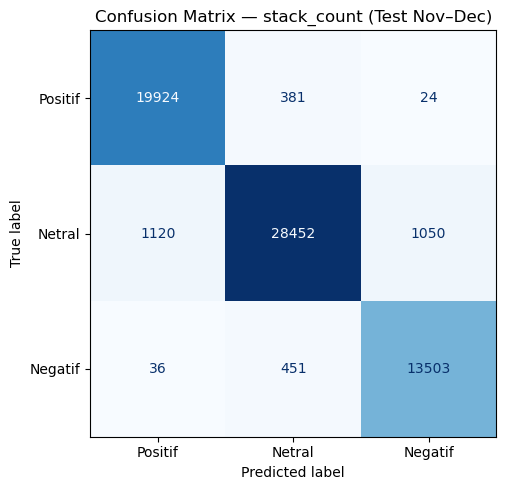

CPU times: total: 41min 26s
Wall time: 5min 29s


In [8]:
%%time
from pathlib import Path
import os, json, joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

ARTE_DIR = Path("artefacts_2024_window_full")
assert ARTE_DIR.exists(), "Folder artefak tidak ditemukan."

# Pastikan search_results tersedia (kalau kernel baru/skip)
if "search_results" not in globals() or not search_results:
    sr_path = ARTE_DIR / "cv_results_2024_window.json"
    assert sr_path.exists(), "cv_results_2024_window.json tidak ada."
    search_results = json.load(open(sr_path, "r", encoding="utf-8"))

# Ambil kandidat terbaik berdasar CV
best_rec   = max(search_results, key=lambda d: d["best_score"])
best_name  = best_rec["name"]
best_score = best_rec["best_score"]

# Ambil estimator: prioritas dari memori, jika tidak ada → load dari artefak
if "best_models" in globals() and best_name in best_models:
    best_est = best_models[best_name]
else:
    model_path = ARTE_DIR / f"best_{best_name}.joblib"
    if not model_path.exists():
        # fallback: cari model terbaik berikutnya yang file-nya tersedia
        for rec in sorted(search_results, key=lambda d: d["best_score"], reverse=True):
            alt = ARTE_DIR / f"best_{rec['name']}.joblib"
            if alt.exists():
                best_name, best_score, model_path = rec["name"], rec["best_score"], alt
                break
    assert model_path.exists(), f"Artefak model tidak ditemukan: {model_path}"
    best_est = joblib.load(model_path)

print(f"🏆 Best by CV (available): {best_name} (f1_macro={best_score:.4f})")

# === Fit ulang di seluruh TRAIN ===
best_est.fit(X_tr, y_tr)

# === Uji di TEST (Nov–Dec) ===
y_pred = best_est.predict(X_te)
acc = accuracy_score(y_te, y_pred)
f1m = f1_score(y_te, y_pred, average="macro")
print(f"\nTest (Nov–Dec) → Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}\n")
print(classification_report(y_te, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_te, y_pred, labels=ALL_LABELS)
disp = ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS)
fig, ax = plt.subplots(figsize=(5.6,5))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title(f"Confusion Matrix — {best_name} (Test Nov–Dec)")
plt.tight_layout()
plt.show()


## 7) Simpan artefak (pipeline + meta)


In [9]:
%%time
pipe_path = os.path.join(ARTE_DIR, f"sentiment_pipeline_2024win_{best_name}.pkl")
dump(best_est, pipe_path)

meta = {
    "best_pipeline": best_name,
    "best_cv": max(d["best_score"] for d in search_results),
    "train_months": train_months,
    "test_months": test_months,
    "test_accuracy": float(acc),
    "test_macro_f1": float(f1m),
    "labels": ALL_LABELS,
    "text_column_used": TEXT_COL,
    "vectorizer": best_est.named_steps["vect"].__class__.__name__,
    "supports_predict_proba": hasattr(best_est, "predict_proba") or hasattr(best_est[-1], "predict_proba"),
    "source_file": INPUT_LABELED,
    "search_results": search_results
}
with open(os.path.join(ARTE_DIR, "model_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ Saved:")
print(" -", pipe_path)
print(" -", os.path.join(ARTE_DIR, "model_meta.json"))


✅ Saved:
 - artefacts_2024_window_full\sentiment_pipeline_2024win_stack_count.pkl
 - artefacts_2024_window_full\model_meta.json
CPU times: total: 547 ms
Wall time: 548 ms


## 8) (Opsional) SMOTE untuk teks — contoh hati-hati
**Peringatan:** SMOTE tidak mendukung matriks *sparse* → perlu `toarray()` (padat) yang **boros RAM**.  
Pakai **feature cap kecil** (mis. `max_features=40k`) dan jalankan hanya jika dataset kecil.


In [10]:
%%time
USE_SMOTE = False  # ubah ke True jika ingin mencoba

if USE_SMOTE:
    SMALL_TFIDF = dict(**TFIDF_KW)
    SMALL_TFIDF["max_features"] = 40_000

    smote_pipe = ImbPipeline([
        ("vect", TfidfVectorizer(**SMALL_TFIDF)),
        ("to_dense", FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)),
        ("smote", SMOTE(random_state=42)),
        ("clf", LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear",
                                   max_iter=2000, multi_class="ovr"))
    ])
    sc = cross_val_score(smote_pipe, X_tr, y_tr, cv=cv, scoring="f1_macro", n_jobs=1)
    print(f"SMOTE TFIDF+LR | F1_macro (train-CV): {sc.mean():.4f} ± {sc.std():.4f}")

    smote_pipe.fit(X_tr, y_tr)
    y_sm = smote_pipe.predict(X_te)
    acc_sm = accuracy_score(y_te, y_sm); f1m_sm = f1_score(y_te, y_sm, average="macro")
    print(f"SMOTE TEST → Acc: {acc_sm:.4f} | Macro-F1: {f1m_sm:.4f}")
else:
    print("SMOTE skipped (recommended for text).")


SMOTE skipped (recommended for text).
CPU times: total: 0 ns
Wall time: 267 μs


## 9) (Opsional) Sanity check singkat


In [11]:
%%time
samples = [
    "i totally support this decision, feels like progress!",
    "not sure this is a good idea",
    "this is the worst policy i've ever seen",
]
pred = best_est.predict(samples)
print(list(zip(samples, pred)))


[('i totally support this decision, feels like progress!', 'Netral'), ('not sure this is a good idea', 'Positif'), ("this is the worst policy i've ever seen", 'Negatif')]
CPU times: total: 0 ns
Wall time: 5.24 ms
